In [1]:
# default_exp seq

# seq

> Rule Set 3 sequence-based model

In [2]:
#export
import joblib
import sglearn
import pandas as pd
import os

In [3]:
import lightgbm
from scipy.stats import spearmanr
import gpplot
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
geckov2_data = pd.read_csv('test_data/Aguirre2016_activity.csv')
sanger_data = pd.read_csv('test_data/Behan2019_activity.csv')
__file__ = os.path.abspath('') + '/00_seq.ipynb'

In [5]:
# export
def load_seq_model():
    """Load rule set 3 sequence model"""
    model = joblib.load(os.path.join(os.path.dirname(__file__), 'RuleSet3.pkl'))
    return model

In [6]:
assert type(load_seq_model()) == lightgbm.sklearn.LGBMRegressor

In [7]:
# export
def featurize_context(context_sequences, sequence_tracr='Hsu2013', ref_tracrs=None,
                      n_jobs=1):
    """Featurize context sequences

    :param context_sequences: list-like
    :param sequence_tracr: list-like or str
    :return: DataFrame, feature matrix
    """
    if ref_tracrs is None:
        ref_tracrs = ['Hsu2013', 'Chen2013']
    context_series = pd.Series(context_sequences)
    if not (context_series.str.len() == 30).all():
        raise  ValueError('All context sequences must be 30 nucleotides')
    featurized_sgrnas = sglearn.featurize_guides(context_sequences,
                                                 n_jobs=n_jobs)
    for tracr in ref_tracrs:
        if type(sequence_tracr) is str:
            featurized_sgrnas[tracr + ' tracr'] = int(sequence_tracr == tracr)
        else: # list-like
            featurized_sgrnas[tracr + ' tracr'] = ((pd.Series(sequence_tracr) == tracr)
                                                   .astype(int)
                                                   .to_list())
    return featurized_sgrnas

In [8]:
test_sgrnas = ['GACGAAAGCGACAACGCGTTCATCCGGGCA', 'AGAAAACACTAGCATCCCCACCCGCGGACT']
sequence_tracr = ['Hsu2013', 'Chen2013']
featurized_test = featurize_context(test_sgrnas, sequence_tracr=sequence_tracr)
assert featurized_test.loc['GACGAAAGCGACAACGCGTTCATCCGGGCA', '-4G'] == 1
assert featurized_test.loc['AGAAAACACTAGCATCCCCACCCGCGGACT', '1AA'] == 1
assert featurized_test.loc['GACGAAAGCGACAACGCGTTCATCCGGGCA', 'Chen2013 tracr'] == 0
assert featurized_test.loc['GACGAAAGCGACAACGCGTTCATCCGGGCA', 'Hsu2013 tracr'] == 1
assert featurized_test.loc['AGAAAACACTAGCATCCCCACCCGCGGACT', 'Chen2013 tracr'] == 1
assert featurized_test.loc['AGAAAACACTAGCATCCCCACCCGCGGACT', 'Hsu2013 tracr'] == 0
featurized_test = featurize_context(test_sgrnas, sequence_tracr='Hsu2013')
assert featurized_test.loc['GACGAAAGCGACAACGCGTTCATCCGGGCA', 'Hsu2013 tracr'] == 1
assert featurized_test.loc['GACGAAAGCGACAACGCGTTCATCCGGGCA', 'Chen2013 tracr'] == 0
assert featurized_test.loc['AGAAAACACTAGCATCCCCACCCGCGGACT', 'Hsu2013 tracr'] == 1
assert featurized_test.loc['AGAAAACACTAGCATCCCCACCCGCGGACT', 'Chen2013 tracr'] == 0

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 173.01it/s]


In [9]:
#export
def predict_seq(context_sequences, sequence_tracr='Hsu2013', ref_tracrs=None, n_jobs=1):
    """Predict the activity of context sequence for SpCas9 Knockout using sequence information only

    :param context_sequences: list of str
    :return: list of float, predictions
    """
    model = load_seq_model()
    print('Calculating sequence-based features')
    featurized_sgrnas = featurize_context(context_sequences, sequence_tracr=sequence_tracr, ref_tracrs=ref_tracrs,
                                          n_jobs=n_jobs)
    seq_predictions = model.predict(featurized_sgrnas)
    return seq_predictions

In [10]:
geckov2_predictions = predict_seq(geckov2_data['sgRNA Context Sequence'],
                                  sequence_tracr='Hsu2013')
assert spearmanr(geckov2_predictions, geckov2_data['avg_mean_centered_neg_lfc'])[0] > 0.5

Calculating sequence-based features


100%|██████████████████████████████████████| 8659/8659 [01:22<00:00, 105.06it/s]


In [11]:
sanger_predictions = predict_seq(sanger_data['sgRNA Context Sequence'],
                                 sequence_tracr='Chen2013')
assert spearmanr(sanger_predictions, sanger_data['avg_mean_centered_neg_lfc'])[0] > 0.25

Calculating sequence-based features


100%|██████████████████████████████████████| 7442/7442 [00:38<00:00, 191.57it/s]


<AxesSubplot:xlabel='prediction', ylabel='activity'>

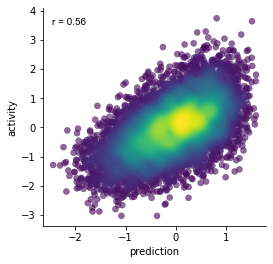

In [12]:
geckov2_activity_df = pd.DataFrame({'activity': geckov2_data['avg_mean_centered_neg_lfc'],
                                    'prediction': geckov2_predictions})
plt.subplots(figsize=(4, 4))
sns.despine()
gpplot.point_densityplot(data=geckov2_activity_df, y='activity', x='prediction')
gpplot.add_correlation(data=geckov2_activity_df, y='activity', x='prediction', method='spearman')